## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_response = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CRM/2 Campaign Response Model/Retail_Data_Response.csv')
df_transactions = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CRM/2 Campaign Response Model/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [ ]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value
                                                     'trans_date': lambda x:(x.max()-x.min()).days    # aou
                                                     })

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value',
                         'trans_date': 'aou'
                         }, inplace=True)
df_rfm['ticket_size'] = df_rfm['monetary_value'] / df_rfm['frequency']

In [ ]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,aou,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [ ]:
index_2year = df_transactions['trans_date'] > df_transactions['trans_date'].max() - pd.DateOffset(years=2)
df_transactions_2years = df_transactions[index_2year]
df_transactions_2years.reset_index()
df_transactions_2years.shape

(65023, 4)

In [ ]:
df_transactions_2years.head()

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
9,CS3802,2013-08-20,75,574.0


In [ ]:
## create data set with RFM variables

df_rfm_2years = df_transactions_2years.groupby('customer_id').agg({#'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()#,                # Monetary Value
                                                     #'trans_date': lambda x:(x.max()-x.min()).days    # aou
                                                     })

df_rfm_2years.rename(columns={#'recent': 'recency', 
                         'customer_id': 'frequency_2y', 
                         'tran_amount': 'monetary_value_2y'#,
                         #'trans_date': 'aou'
                         }, inplace=True)
df_rfm_2years['ticket_size_2y'] = df_rfm_2years['monetary_value_2y'] / df_rfm_2years['frequency_2y']

In [ ]:
df_rfm_2years = df_rfm_2years.reset_index()
df_rfm_2years.head()

,customer_id,frequency_2y,monetary_value_2y,ticket_size_2y
0,CS1112,6,358,59.666667
1,CS1113,11,775,70.454545
2,CS1114,11,804,73.090909
3,CS1115,11,831,75.545455
4,CS1116,5,333,66.600000


In [ ]:
df_rfm_merged = pd.merge(df_rfm, df_rfm_2years, on='customer_id')

## **Calculating response rate**

In [ ]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


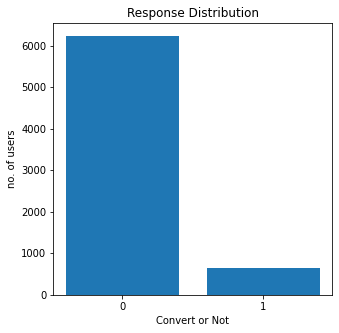

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm_merged)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value,aou,ticket_size,frequency_2y,monetary_value_2y,ticket_size_2y
0,CS1112,0,62.0,15,1012,1309,67.466667,6,358,59.666667
1,CS1113,0,36.0,20,1490,1354,74.500000,11,775,70.454545
2,CS1114,1,33.0,19,1432,1309,75.368421,11,804,73.090909
3,CS1115,1,12.0,22,1659,1303,75.409091,11,831,75.545455
4,CS1116,1,204.0,13,857,1155,65.923077,5,333,66.600000


## **Creating train and test dataset**

In [ ]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 8)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 8)
Number transactions y_test dataset:  (2066,)


In [ ]:
X_train.head()

,recency,frequency,monetary_value,aou,ticket_size,frequency_2y,monetary_value_2y,ticket_size_2y
6590,115.0,12,564,1265,47.000000,5,232,46.400000
567,8.0,28,1976,1385,70.571429,14,895,63.928571
2468,425.0,19,1413,940,74.368421,4,370,92.500000
1149,249.0,18,1183,1120,65.722222,7,428,61.142857
2752,139.0,25,1880,1247,75.200000,13,972,74.769231


Text(0.5, 1.0, 'Imbalanced Data')

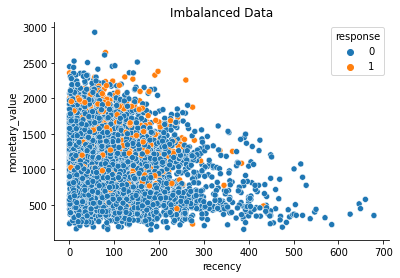

In [ ]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

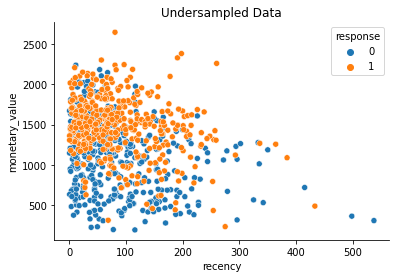

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'aou', 'ticket_size', 'frequency_2y', 'monetary_value_2y', 'ticket_size_2y', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

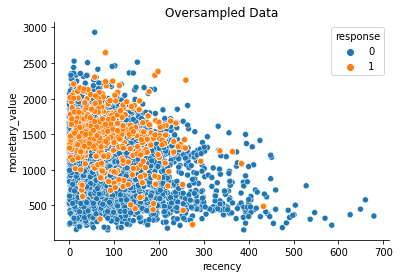

In [ ]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'aou', 'ticket_size', 'frequency_2y', 'monetary_value_2y', 'ticket_size_2y', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

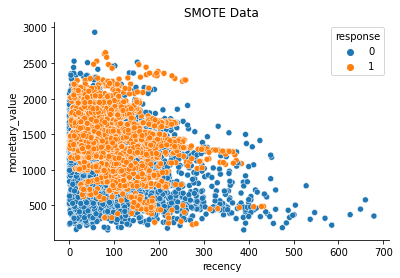

In [ ]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value', 'aou', 'ticket_size', 'frequency_2y', 'monetary_value_2y', 'ticket_size_2y', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

In [ ]:
def train_model(ML, X_train, y_train, X_test, y_test, model_parameter={}):
  predicted_y = []
  expected_y = []

  model = ML.fit(X=X_train, y=y_train,**model_parameter)
  predictions = model.predict(X_train)
  predicted_y.extend(predictions)
  expected_y.extend(y_train)
  report_train = classification_report(expected_y, predicted_y)
  print('training set')
  print(report_train) 

  predicted_y = []
  expected_y = []
  predictions = model.predict(X_test.to_numpy())
  predicted_y.extend(predictions)
  expected_y.extend(y_test)
  report_test = classification_report(expected_y, predicted_y)
  print('test set')
  print(report_test) 

  return model

In [ ]:
def plot_roc_logreg(X_train,y_train,X_test, y_test,func):
  y_score_train = func(X_train)
  fpr_train, tpr_train, _ = roc_curve(y_train,  y_score_train)
  auc_train = roc_auc_score(y_train, y_score_train)
  plt.plot(fpr_train,tpr_train, color='red', label='train , auc='+str(auc_train))

  y_score_test = func(X_test)
  fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
  auc_test = roc_auc_score(y_test, y_score_test)
  plt.plot(fpr_test,tpr_test, color='Blue', label='test , auc='+str(auc_test))

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.legend(loc=4)
  plt.show()

In [ ]:
def plot_roc_xgb(X_train,y_train,X_test, y_test,func):
  y_score_train = func(X_train)
  fpr_train, tpr_train, _ = roc_curve(y_train,  y_score_train[:,1])
  auc_train = roc_auc_score(y_train, y_score_train[:,1])
  plt.plot(fpr_train,tpr_train, color='red', label='train , auc='+str(auc_train))

  y_score_test = func(X_test.to_numpy())
  fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
  auc_test = roc_auc_score(y_test, y_score_test[:,1])
  plt.plot(fpr_test,tpr_test, color='Blue', label='test , auc='+str(auc_test))

  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.legend(loc=4)
  plt.show()

## **Logistic Regression Model**

In [ ]:
# grid search of logistict regression
param_grid={
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'penalty' : ['l1', 'l2'],
                'class_weight': ['balanced'],
                'C': [0.1, 1, 10, 100]
}
search_logreg = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid,scoring='roc_auc')

### undersampled

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.73      0.70      0.72       429
           1       0.71      0.75      0.73       429

    accuracy                           0.72       858
   macro avg       0.72      0.72      0.72       858
weighted avg       0.72      0.72      0.72       858

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.78      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



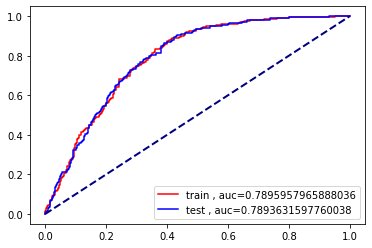

[[ 0.00564557 -0.39975209  0.00589089 -0.0009691  -0.10674041  0.47456595
  -0.00190878  0.06646424]] [-0.21387501]


In [ ]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg_model_under = train_model(logreg,X_undersampled, y_undersampled,X_test,y_test)
plot_roc_logreg(X_undersampled, y_undersampled,X_test,y_test,logreg_model_under.decision_function)
print(logreg_model_under.coef_, logreg_model_under.intercept_)

logistic regression model (grid search) - undersampled


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear

training set
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       429
           1       0.71      0.77      0.74       429

    accuracy                           0.72       858
   macro avg       0.73      0.72      0.72       858
weighted avg       0.73      0.72      0.72       858

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.78      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



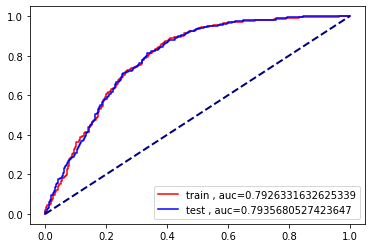

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
print('logistic regression model (grid search) - undersampled')
gridsearch_logreg_under = train_model(search_logreg,X_undersampled, y_undersampled,X_test, y_test)
plot_roc_logreg(X_undersampled, y_undersampled,X_test,y_test,gridsearch_logreg_under.decision_function)
print(gridsearch_logreg_under.best_params_)

### oversampled

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      4389
           1       0.71      0.74      0.72      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.22      0.77      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.70      0.75      2066



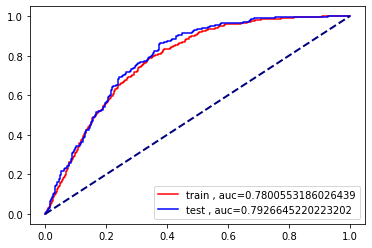

[[ 5.37544326e-03 -2.76944567e-01  3.99728625e-03 -1.25799815e-03
  -6.19430365e-02  3.55162338e-01 -1.23696278e-04  2.92523297e-02]] [-0.24859954]


In [ ]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg_model_over = train_model(logreg,X_oversampled, y_oversampled,X_test,y_test)
plot_roc_logreg(X_oversampled, y_oversampled,X_test,y_test,logreg_model_over.decision_function)
print(logreg_model_over.coef_, logreg_model_over.intercept_)

logistic regression model (grid search) - oversampled


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o

training set
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      4389
           1       0.71      0.75      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.23      0.78      0.35       218

    accuracy                           0.70      2066
   macro avg       0.60      0.73      0.58      2066
weighted avg       0.89      0.70      0.76      2066



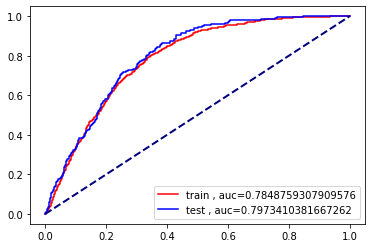

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
print('logistic regression model (grid search) - oversampled')
gridsearch_logreg_over = train_model(search_logreg,X_oversampled, y_oversampled,X_test, y_test)
plot_roc_logreg(X_oversampled, y_oversampled,X_test,y_test,gridsearch_logreg_over.decision_function)
print(gridsearch_logreg_over.best_params_)

### SMOTE

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      4389
           1       0.71      0.75      0.73      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.23      0.77      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.73      0.58      2066
weighted avg       0.88      0.70      0.76      2066



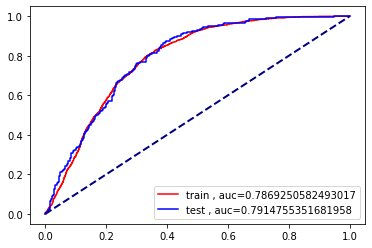

[[ 0.00580663 -0.40130219  0.00554541 -0.00078063 -0.08641663  0.48908594
  -0.00160044  0.0473082 ]] [-0.21387501]


In [ ]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg_model_SMOTE = train_model(logreg,X_SMOTE, y_SMOTE,X_test,y_test)
plot_roc_logreg(X_SMOTE, y_SMOTE,X_test,y_test,logreg_model_SMOTE.decision_function)
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

logistic regression model (grid search) - SMOTE


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number o

training set
              precision    recall  f1-score   support

           0       0.76      0.69      0.72      4389
           1       0.71      0.78      0.74      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.73      8778
weighted avg       0.73      0.73      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.81      1848
           1       0.23      0.76      0.35       218

    accuracy                           0.70      2066
   macro avg       0.59      0.73      0.58      2066
weighted avg       0.88      0.70      0.76      2066



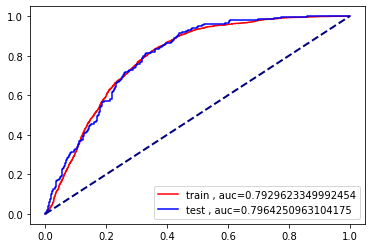

{'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
print('logistic regression model (grid search) - SMOTE')
gridsearch_logreg_SMOTE = train_model(search_logreg,X_SMOTE, y_SMOTE,X_test, y_test)
plot_roc_logreg(X_SMOTE, y_SMOTE,X_test,y_test,gridsearch_logreg_SMOTE.decision_function)
print(gridsearch_logreg_SMOTE.best_params_)

## **SVM**

In [ ]:
# grid search of svm
param_grid={
                'C': [0.1, 1, 10, 100, 1000],
                #'gamma': [0.1, 0.01],
                'kernel': ['rbf', 'poly', 'sigmoid']
}
search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid,scoring='roc_auc')

### oversampled

Support Vector Machine - oversampled
training set
              precision    recall  f1-score   support

           0       0.78      0.61      0.69      4389
           1       0.68      0.82      0.75      4389

    accuracy                           0.72      8778
   macro avg       0.73      0.72      0.72      8778
weighted avg       0.73      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1848
           1       0.21      0.83      0.33       218

    accuracy                           0.64      2066
   macro avg       0.59      0.73      0.54      2066
weighted avg       0.89      0.64      0.71      2066



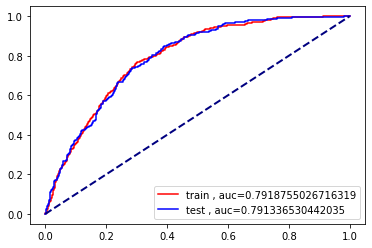

[-2.61412906]


In [ ]:
print('Support Vector Machine - oversampled')
support_vector_machine = SVC()
svm_model_over = train_model(support_vector_machine,X_oversampled, y_oversampled,X_test,y_test)
plot_roc_logreg(X_oversampled, y_oversampled,X_test,y_test,svm_model_over.decision_function)
print(svm_model_over.intercept_)

svm model (grid search) - oversampled
training set
              precision    recall  f1-score   support

           0       0.81      0.61      0.70      4389
           1       0.69      0.86      0.77      4389

    accuracy                           0.74      8778
   macro avg       0.75      0.74      0.73      8778
weighted avg       0.75      0.74      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1848
           1       0.21      0.83      0.33       218

    accuracy                           0.64      2066
   macro avg       0.59      0.73      0.54      2066
weighted avg       0.89      0.64      0.71      2066



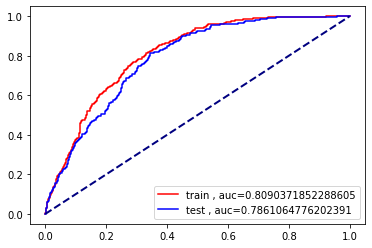

{'C': 1000, 'kernel': 'rbf'}


In [ ]:
print('svm model (grid search) - oversampled')
gridsearch_svm_over = train_model(search_svm,X_oversampled, y_oversampled,X_test, y_test)
plot_roc_logreg(X_oversampled, y_oversampled,X_test,y_test,gridsearch_svm_over.decision_function)
print(gridsearch_svm_over.best_params_)

### undersampled

Support Vector Machine - undersampled
training set
              precision    recall  f1-score   support

           0       0.79      0.63      0.70       429
           1       0.69      0.83      0.75       429

    accuracy                           0.73       858
   macro avg       0.74      0.73      0.73       858
weighted avg       0.74      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1848
           1       0.20      0.82      0.32       218

    accuracy                           0.62      2066
   macro avg       0.58      0.71      0.53      2066
weighted avg       0.88      0.62      0.70      2066



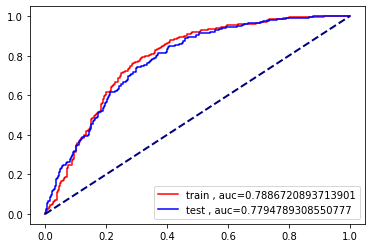

[-0.78588037]


In [ ]:
print('Support Vector Machine - undersampled')
support_vector_machine = SVC()
svm_model_under = train_model(support_vector_machine,X_undersampled, y_undersampled,X_test,y_test)
plot_roc_logreg(X_undersampled, y_undersampled,X_test,y_test,svm_model_under.decision_function)
print(svm_model_under.intercept_)

svm model (grid search) - undersampled
training set
              precision    recall  f1-score   support

           0       0.82      0.65      0.72       429
           1       0.71      0.85      0.77       429

    accuracy                           0.75       858
   macro avg       0.76      0.75      0.75       858
weighted avg       0.76      0.75      0.75       858

test set
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1848
           1       0.20      0.81      0.32       218

    accuracy                           0.64      2066
   macro avg       0.58      0.71      0.53      2066
weighted avg       0.88      0.64      0.71      2066



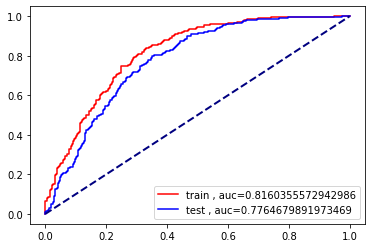

{'C': 1000, 'kernel': 'rbf'}


In [ ]:
print('svm model (grid search) - undersampled')
gridsearch_svm_under = train_model(search_svm,X_undersampled, y_undersampled,X_test, y_test)
plot_roc_logreg(X_undersampled, y_undersampled,X_test,y_test,gridsearch_svm_under.decision_function)
print(gridsearch_svm_under.best_params_)

### SMOTE

Support Vector Machine - SMOTE
training set
              precision    recall  f1-score   support

           0       0.81      0.62      0.70      4389
           1       0.69      0.85      0.76      4389

    accuracy                           0.74      8778
   macro avg       0.75      0.74      0.73      8778
weighted avg       0.75      0.74      0.73      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.63      0.76      1848
           1       0.21      0.83      0.33       218

    accuracy                           0.65      2066
   macro avg       0.59      0.73      0.55      2066
weighted avg       0.89      0.65      0.72      2066



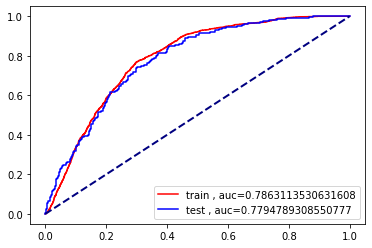

[-3.93719121]


In [ ]:
print('Support Vector Machine - SMOTE')
support_vector_machine = SVC()
svm_model_SMOTE = train_model(support_vector_machine,X_SMOTE, y_SMOTE,X_test,y_test)
plot_roc_logreg(X_SMOTE, y_SMOTE,X_test,y_test,svm_model_under.decision_function)
print(svm_model_SMOTE.intercept_)

svm model (grid search) - SMOTE
training set
              precision    recall  f1-score   support

           0       0.83      0.62      0.71      4389
           1       0.70      0.88      0.78      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.74      8778
weighted avg       0.76      0.75      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1848
           1       0.21      0.81      0.33       218

    accuracy                           0.65      2066
   macro avg       0.59      0.72      0.55      2066
weighted avg       0.89      0.65      0.72      2066



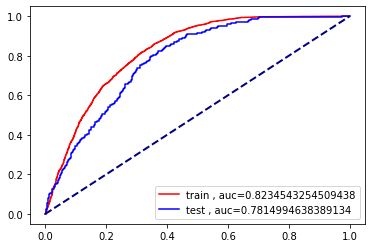

{'C': 1000, 'kernel': 'rbf'}


In [ ]:
print('svm model (grid search) - SMOTE')
gridsearch_svm_SMOTE = train_model(search_svm,X_SMOTE, y_SMOTE,X_test, y_test)
plot_roc_logreg(X_SMOTE, y_SMOTE,X_test,y_test,gridsearch_svm_SMOTE.decision_function)
print(gridsearch_svm_SMOTE.best_params_)

## **Decision Tree**

In [ ]:
# grid search of decision tree
param_grid={
                'criterion' : ['gini','entropy'],
                'max_depth': [1,2,3,4,5],
                'max_features': [None, "auto", "sqrt", "log2"],
                'min_samples_leaf': [1, 5, 10, 20, 50, 100]
}
search_dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid,scoring='roc_auc')

### oversampled

Decision Tree - oversampled
training set
              precision    recall  f1-score   support

           0       0.81      0.56      0.66      4389
           1       0.66      0.87      0.75      4389

    accuracy                           0.71      8778
   macro avg       0.74      0.71      0.71      8778
weighted avg       0.74      0.71      0.71      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.56      0.71      1848
           1       0.18      0.84      0.30       218

    accuracy                           0.59      2066
   macro avg       0.58      0.70      0.51      2066
weighted avg       0.89      0.59      0.67      2066



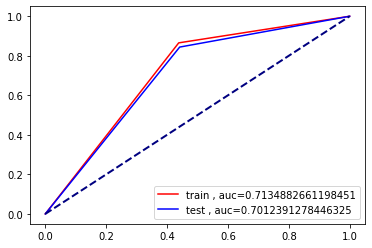

In [ ]:
print('Decision Tree - oversampled')
clf = DecisionTreeClassifier(min_impurity_decrease=0.05)
clf_model_over = train_model(clf,X_oversampled, y_oversampled,X_test,y_test)
plot_roc_xgb(X_oversampled, y_oversampled,X_test,y_test,clf_model_over.predict_proba)

Decision Tree (grid search) - oversampled
training set
              precision    recall  f1-score   support

           0       0.89      0.61      0.72      4389
           1       0.70      0.92      0.80      4389

    accuracy                           0.76      8778
   macro avg       0.79      0.76      0.76      8778
weighted avg       0.79      0.76      0.76      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      1848
           1       0.20      0.83      0.32       218

    accuracy                           0.63      2066
   macro avg       0.58      0.71      0.53      2066
weighted avg       0.89      0.63      0.70      2066



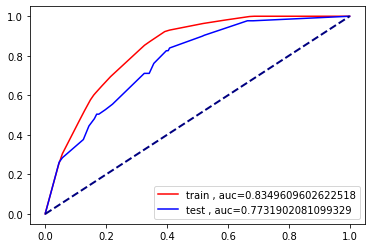

{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10}


In [ ]:
print('Decision Tree (grid search) - oversampled')
gridsearch_dt_over = train_model(search_dt,X_oversampled, y_oversampled,X_test, y_test)
plot_roc_xgb(X_oversampled, y_oversampled,X_test,y_test,gridsearch_dt_over.predict_proba)
print(gridsearch_dt_over.best_params_)

### undersampled

Decision Tree - undersampled
training set
              precision    recall  f1-score   support

           0       0.82      0.59      0.69       429
           1       0.68      0.87      0.76       429

    accuracy                           0.73       858
   macro avg       0.75      0.73      0.73       858
weighted avg       0.75      0.73      0.73       858

test set
              precision    recall  f1-score   support

           0       0.97      0.56      0.71      1848
           1       0.18      0.84      0.30       218

    accuracy                           0.59      2066
   macro avg       0.58      0.70      0.51      2066
weighted avg       0.89      0.59      0.67      2066



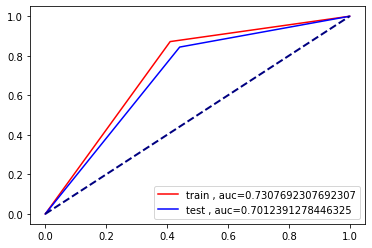

In [ ]:
print('Decision Tree - undersampled')
clf = DecisionTreeClassifier(min_impurity_decrease=0.05)
clf_model_under = train_model(clf,X_undersampled, y_undersampled,X_test,y_test)
plot_roc_xgb(X_undersampled, y_undersampled,X_test,y_test,clf_model_under.predict_proba)

Decision Tree (grid search) - undersampled
training set
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       429
           1       0.73      0.83      0.78       429

    accuracy                           0.76       858
   macro avg       0.76      0.76      0.76       858
weighted avg       0.76      0.76      0.76       858

test set
              precision    recall  f1-score   support

           0       0.96      0.61      0.75      1848
           1       0.19      0.77      0.30       218

    accuracy                           0.63      2066
   macro avg       0.57      0.69      0.53      2066
weighted avg       0.88      0.63      0.70      2066



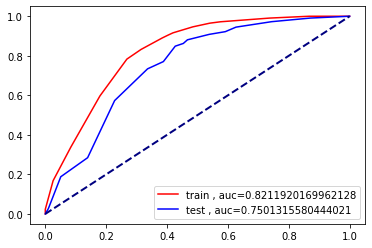

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 10}


In [ ]:
print('Decision Tree (grid search) - undersampled')
gridsearch_dt_under = train_model(search_dt,X_undersampled, y_undersampled,X_test, y_test)
plot_roc_xgb(X_undersampled, y_undersampled,X_test,y_test,gridsearch_dt_under.predict_proba)
print(gridsearch_dt_under.best_params_)

### SMOTE

Decision Tree - SMOTE
training set
              precision    recall  f1-score   support

           0       0.83      0.56      0.67      4389
           1       0.67      0.88      0.76      4389

    accuracy                           0.72      8778
   macro avg       0.75      0.72      0.72      8778
weighted avg       0.75      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.56      0.71      1848
           1       0.18      0.84      0.30       218

    accuracy                           0.59      2066
   macro avg       0.58      0.70      0.51      2066
weighted avg       0.88      0.59      0.67      2066



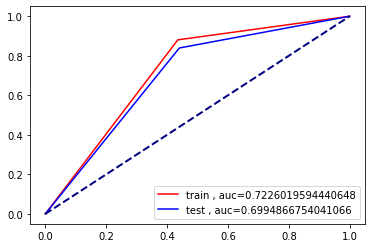

In [ ]:
print('Decision Tree - SMOTE')
clf = DecisionTreeClassifier(min_impurity_decrease=0.05)
clf_model_SMOTE = train_model(clf,X_SMOTE, y_SMOTE,X_test,y_test)
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,clf_model_SMOTE.predict_proba)

Decision Tree (grid search) - SMOTE
training set
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      4389
           1       0.72      0.88      0.79      4389

    accuracy                           0.77      8778
   macro avg       0.78      0.77      0.77      8778
weighted avg       0.78      0.77      0.77      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.66      0.78      1848
           1       0.20      0.72      0.31       218

    accuracy                           0.67      2066
   macro avg       0.58      0.69      0.55      2066
weighted avg       0.87      0.67      0.73      2066



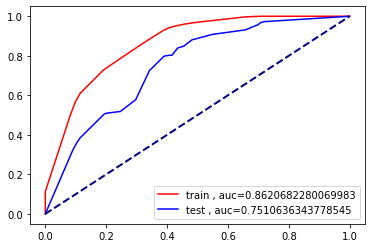

{'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 20}


In [ ]:
print('Decision Tree (grid search) - SMOTE')
gridsearch_dt_SMOTE = train_model(search_dt,X_SMOTE, y_SMOTE,X_test, y_test)
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,gridsearch_dt_SMOTE.predict_proba)
print(gridsearch_dt_SMOTE.best_params_)

## **Random Forest**

In [ ]:
# grid search of random forest
param_grid={
                'bootstrap': [True, False],
                'max_depth': [5,10, 15],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [ 5, 10, 20]#,
                #'min_samples_split': [2, 5, 10],
                #'n_estimators': [200, 400, 600]
}
search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,scoring='roc_auc')

### undersampled

Random Forest - undersampled
training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       429
           1       1.00      1.00      1.00       429

    accuracy                           1.00       858
   macro avg       1.00      1.00      1.00       858
weighted avg       1.00      1.00      1.00       858

test set
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      1848
           1       0.20      0.73      0.31       218

    accuracy                           0.66      2066
   macro avg       0.58      0.69      0.54      2066
weighted avg       0.87      0.66      0.72      2066



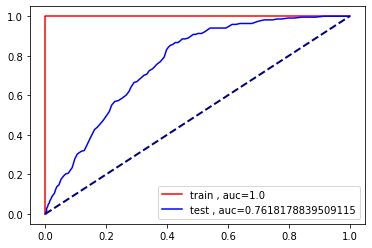

In [ ]:
print('Random Forest - undersampled')
random_forest = RandomForestClassifier(n_estimators=100)
random_forest_model_under = train_model(random_forest,X_undersampled, y_undersampled,X_test,y_test)
plot_roc_xgb(X_undersampled, y_undersampled,X_test,y_test,random_forest_model_under.predict_proba)

Random Forest (grid search) - undersampled
training set
              precision    recall  f1-score   support

           0       0.80      0.68      0.74       429
           1       0.72      0.83      0.77       429

    accuracy                           0.76       858
   macro avg       0.76      0.76      0.76       858
weighted avg       0.76      0.76      0.76       858

test set
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1848
           1       0.21      0.80      0.33       218

    accuracy                           0.66      2066
   macro avg       0.59      0.72      0.55      2066
weighted avg       0.89      0.66      0.72      2066



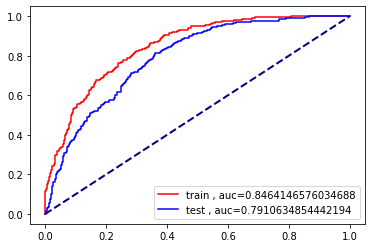

{'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 20}


In [ ]:
print('Random Forest (grid search) - undersampled')
gridsearch_rf_under = train_model(search_rf,X_undersampled, y_undersampled,X_test, y_test)
plot_roc_xgb(X_undersampled, y_undersampled,X_test,y_test,gridsearch_rf_under.predict_proba)
print(gridsearch_rf_under.best_params_)

### oversampled

Random Forest - oversampled
training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4389
           1       1.00      1.00      1.00      4389

    accuracy                           1.00      8778
   macro avg       1.00      1.00      1.00      8778
weighted avg       1.00      1.00      1.00      8778

test set
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1848
           1       0.31      0.08      0.13       218

    accuracy                           0.88      2066
   macro avg       0.61      0.53      0.53      2066
weighted avg       0.84      0.88      0.85      2066



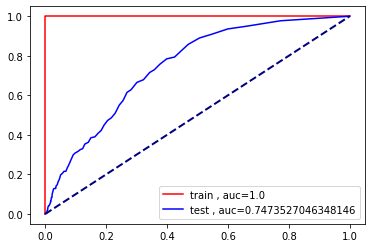

In [ ]:
print('Random Forest - oversampled')
random_forest = RandomForestClassifier(n_estimators=100)
random_forest_model_over = train_model(random_forest,X_oversampled, y_oversampled,X_test,y_test)
plot_roc_xgb(X_oversampled, y_oversampled,X_test,y_test,random_forest_model_over.predict_proba)

Random Forest (grid search) - oversampled
training set
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      4389
           1       0.96      1.00      0.98      4389

    accuracy                           0.98      8778
   macro avg       0.98      0.98      0.98      8778
weighted avg       0.98      0.98      0.98      8778

test set
              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1848
           1       0.28      0.29      0.29       218

    accuracy                           0.85      2066
   macro avg       0.60      0.60      0.60      2066
weighted avg       0.85      0.85      0.85      2066



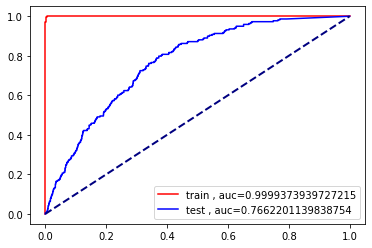

{'bootstrap': False, 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 5}


In [ ]:
print('Random Forest (grid search) - oversampled')
gridsearch_rf_over = train_model(search_rf,X_oversampled, y_oversampled,X_test, y_test)
plot_roc_xgb(X_oversampled, y_oversampled,X_test,y_test,gridsearch_rf_over.predict_proba)
print(gridsearch_rf_over.best_params_)

### SMOTE

Random Forest - SMOTE
training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4389
           1       1.00      1.00      1.00      4389

    accuracy                           1.00      8778
   macro avg       1.00      1.00      1.00      8778
weighted avg       1.00      1.00      1.00      8778

test set
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1848
           1       0.23      0.22      0.22       218

    accuracy                           0.84      2066
   macro avg       0.57      0.57      0.57      2066
weighted avg       0.84      0.84      0.84      2066



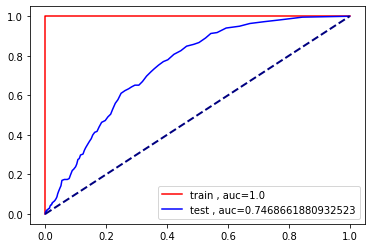

In [ ]:
print('Random Forest - SMOTE')
random_forest = RandomForestClassifier(n_estimators=100)
random_forest_model_SMOTE = train_model(random_forest,X_SMOTE, y_SMOTE,X_test,y_test)
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,random_forest_model_SMOTE.predict_proba)

Random Forest (grid search) - SMOTE
training set
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      4389
           1       0.95      0.99      0.97      4389

    accuracy                           0.97      8778
   macro avg       0.97      0.97      0.97      8778
weighted avg       0.97      0.97      0.97      8778

test set
              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1848
           1       0.27      0.39      0.32       218

    accuracy                           0.82      2066
   macro avg       0.60      0.63      0.61      2066
weighted avg       0.85      0.82      0.84      2066



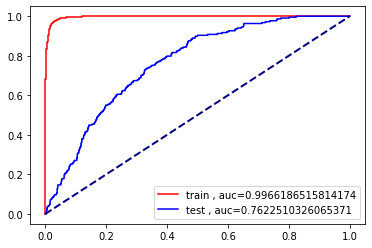

{'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5}


In [ ]:
print('Random Forest (grid search) - SMOTE')
gridsearch_rf_SMOTE = train_model(search_rf,X_SMOTE, y_SMOTE,X_test, y_test)
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,gridsearch_rf_SMOTE.predict_proba)
print(gridsearch_rf_SMOTE.best_params_)

## **XGBoost**

In [ ]:
# grid search of XGBoost
param_grid={
                'min_child_weight': [1, 5, 10],
                'gamma': [0.5, 1, 1.5, 2, 5],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'max_depth': [3, 4, 5],
                'early_stopping_rounds':[5],
                'eval_set':[(X_test.to_numpy(), y_test)],
                'objective':['binary:logistic'], 
                'eval_metric':["auc"]
}
search_xgb = GridSearchCV(estimator=xgb.XGBClassifier(), 
                          param_grid=param_grid,
                          scoring='roc_auc')

### undersampled

In [ ]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
model_parameter = {'early_stopping_rounds':5, 
                   'eval_set':[(X_test.to_numpy(), y_test)]}
xgb_model_under = train_model(xgb_model,X_undersampled,y_undersampled,
                              X_test,y_test,model_parameter)

XGBoost model - undersampled
[0]	validation_0-auc:0.780029
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.789623
[2]	validation_0-auc:0.795294
[3]	validation_0-auc:0.792547
[4]	validation_0-auc:0.793031
[5]	validation_0-auc:0.796322
[6]	validation_0-auc:0.795762
[7]	validation_0-auc:0.796295
[8]	validation_0-auc:0.796105
[9]	validation_0-auc:0.79771
[10]	validation_0-auc:0.799409
[11]	validation_0-auc:0.800915
[12]	validation_0-auc:0.803005
[13]	validation_0-auc:0.803164
[14]	validation_0-auc:0.802253
[15]	validation_0-auc:0.802734
[16]	validation_0-auc:0.803089
[17]	validation_0-auc:0.804057
[18]	validation_0-auc:0.804028
[19]	validation_0-auc:0.804441
[20]	validation_0-auc:0.803131
[21]	validation_0-auc:0.803444
[22]	validation_0-auc:0.801582
[23]	validation_0-auc:0.802391
[24]	validation_0-auc:0.800975
Stopping. Best iteration:
[19]	validation_0-auc:0.804441

training set
              precision    recall  f1-score   support

           0      

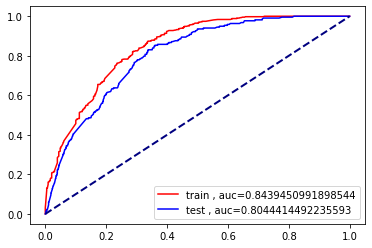

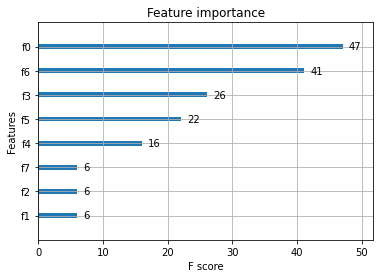

In [ ]:
plot_roc_xgb(X_undersampled, y_undersampled,X_test,y_test,
             xgb_model_under.predict_proba)
xgb.plot_importance(xgb_model_under)

XGBoost (grid search) - undersampled
training set
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       429
           1       0.73      0.83      0.78       429

    accuracy                           0.76       858
   macro avg       0.77      0.76      0.76       858
weighted avg       0.77      0.76      0.76       858

test set
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1848
           1       0.21      0.82      0.34       218

    accuracy                           0.66      2066
   macro avg       0.59      0.73      0.56      2066
weighted avg       0.89      0.66      0.73      2066



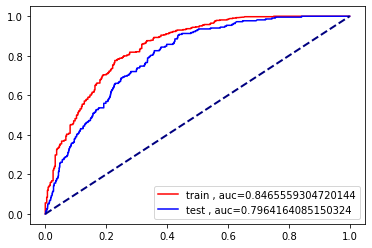

{'colsample_bytree': 0.8, 'early_stopping_rounds': 5, 'eval_metric': 'auc', 'eval_set': (array([[  28.        ,   18.        ,  788.        , ...,    7.        ,
         286.        ,   40.85714286],
       [ 158.        ,   31.        , 2099.        , ...,   12.        ,
         839.        ,   69.91666667],
       [  90.        ,   13.        ,  694.        , ...,    6.        ,
         336.        ,   56.        ],
       ...,
       [  74.        ,   20.        , 1441.        , ...,    4.        ,
         322.        ,   80.5       ],
       [ 191.        ,   19.        , 1259.        , ...,    8.        ,
         561.        ,   70.125     ],
       [  14.        ,   16.        , 1077.        , ...,    8.        ,
         467.        ,   58.375     ]]), 5546    0
3027    1
6234    0
4308    0
3035    0
       ..
2266    0
1303    0
474     0
1789    0
3617    0
Name: response, Length: 2066, dtype: int64), 'gamma': 5, 'max_depth': 3, 'min_child_weight': 10, 'objective': 'bina

In [ ]:
print('XGBoost (grid search) - undersampled')
gridsearch_xgb_under = train_model(search_xgb,X_undersampled, y_undersampled,X_test, y_test)
plot_roc_xgb(X_undersampled, y_undersampled,X_test,y_test,gridsearch_xgb_under.predict_proba)
print(gridsearch_xgb_under.best_params_)
#xgb.plot_importance(gridsearch_xgb_under)

### oversampled

In [ ]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
model_parameter = {'early_stopping_rounds':5, 'eval_set':[(X_test.to_numpy(), y_test)]}
xgb_model_over = train_model(xgb_model,X_oversampled, y_oversampled,X_test,y_test,model_parameter)

XGBoost model - oversampled
[0]	validation_0-auc:0.788769
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.790766
[2]	validation_0-auc:0.793238
[3]	validation_0-auc:0.793505
[4]	validation_0-auc:0.795481
[5]	validation_0-auc:0.796852
[6]	validation_0-auc:0.797398
[7]	validation_0-auc:0.79818
[8]	validation_0-auc:0.798899
[9]	validation_0-auc:0.800099
[10]	validation_0-auc:0.800465
[11]	validation_0-auc:0.800774
[12]	validation_0-auc:0.799755
[13]	validation_0-auc:0.801174
[14]	validation_0-auc:0.800166
[15]	validation_0-auc:0.80063
[16]	validation_0-auc:0.800101
[17]	validation_0-auc:0.800868
[18]	validation_0-auc:0.799964
Stopping. Best iteration:
[13]	validation_0-auc:0.801174

training set
              precision    recall  f1-score   support

           0       0.81      0.67      0.73      4389
           1       0.72      0.84      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75

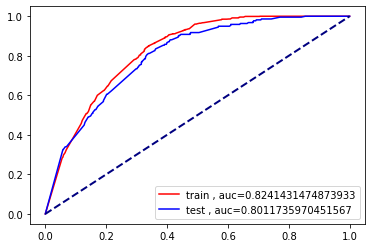

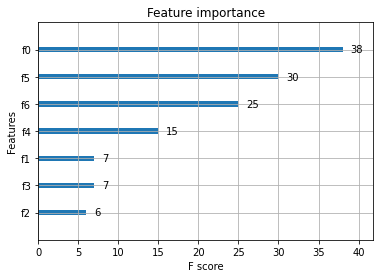

In [ ]:
plot_roc_xgb(X_oversampled, y_oversampled,X_test,y_test,xgb_model_over.predict_proba)
xgb.plot_importance(xgb_model_over)

XGBoost (grid search) - oversampled
training set
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      4389
           1       0.86      0.99      0.92      4389

    accuracy                           0.92      8778
   macro avg       0.92      0.92      0.92      8778
weighted avg       0.92      0.92      0.92      8778

test set
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1848
           1       0.23      0.50      0.31       218

    accuracy                           0.77      2066
   macro avg       0.58      0.65      0.59      2066
weighted avg       0.86      0.77      0.81      2066



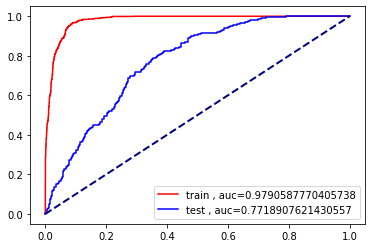

{'colsample_bytree': 1.0, 'early_stopping_rounds': 5, 'eval_metric': 'auc', 'eval_set': (array([[  28.        ,   18.        ,  788.        , ...,    7.        ,
         286.        ,   40.85714286],
       [ 158.        ,   31.        , 2099.        , ...,   12.        ,
         839.        ,   69.91666667],
       [  90.        ,   13.        ,  694.        , ...,    6.        ,
         336.        ,   56.        ],
       ...,
       [  74.        ,   20.        , 1441.        , ...,    4.        ,
         322.        ,   80.5       ],
       [ 191.        ,   19.        , 1259.        , ...,    8.        ,
         561.        ,   70.125     ],
       [  14.        ,   16.        , 1077.        , ...,    8.        ,
         467.        ,   58.375     ]]), 5546    0
3027    1
6234    0
4308    0
3035    0
       ..
2266    0
1303    0
474     0
1789    0
3617    0
Name: response, Length: 2066, dtype: int64), 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'objective': 'bin

In [ ]:
print('XGBoost (grid search) - oversampled')
gridsearch_xgb_over = train_model(search_xgb,X_oversampled, y_oversampled,X_test, y_test)
plot_roc_xgb(X_oversampled, y_oversampled,X_test,y_test,gridsearch_xgb_over.predict_proba)
print(gridsearch_xgb_over.best_params_)
#xgb.plot_importance(gridsearch_xgb_over)

### SMOTE

In [ ]:
print('XGBoost model - SMOTE')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
model_parameter = {'early_stopping_rounds':5, 'eval_set':[(X_test.to_numpy(), y_test)]}
xgb_model_SMOTE = train_model(xgb_model,X_SMOTE, y_SMOTE,X_test,y_test,model_parameter)

XGBoost model - SMOTE
[0]	validation_0-auc:0.785636
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.784157
[2]	validation_0-auc:0.7873
[3]	validation_0-auc:0.791678
[4]	validation_0-auc:0.789817
[5]	validation_0-auc:0.790584
[6]	validation_0-auc:0.792209
[7]	validation_0-auc:0.792255
[8]	validation_0-auc:0.792388
[9]	validation_0-auc:0.792508
[10]	validation_0-auc:0.791669
[11]	validation_0-auc:0.791759
[12]	validation_0-auc:0.790643
[13]	validation_0-auc:0.791608
[14]	validation_0-auc:0.795818
[15]	validation_0-auc:0.796033
[16]	validation_0-auc:0.795102
[17]	validation_0-auc:0.795993
[18]	validation_0-auc:0.795544
[19]	validation_0-auc:0.795379
[20]	validation_0-auc:0.794412
Stopping. Best iteration:
[15]	validation_0-auc:0.796033

training set
              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4389
           1       0.75      0.89      0.81      4389

    accuracy                           0.

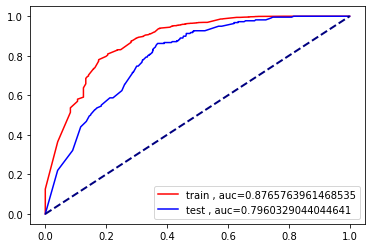

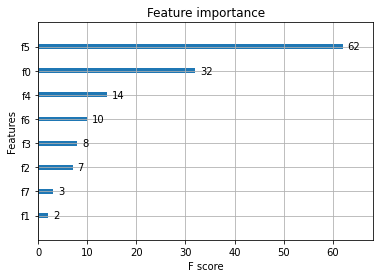

In [ ]:
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,xgb_model_SMOTE.predict_proba)
xgb.plot_importance(xgb_model_SMOTE)

In [ ]:
print('XGBoost model - SMOTE')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
                               base_score=0.5,
                               learning_rate =0.01,
                               n_estimators=5000,
                               max_depth=3,
                               min_child_weight=2,
                               gamma=0.1,
                               subsample=0.4,
                               colsample_bytree=0.4,
                               nthread=4)
model_parameter = {'early_stopping_rounds':5, 'eval_set':[(X_test.to_numpy(), y_test)]}
xgb_model_SMOTE_tuned = train_model(xgb_model,X_SMOTE, y_SMOTE,X_test,y_test,model_parameter)

XGBoost model - SMOTE
[0]	validation_0-auc:0.748763
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.785482
[2]	validation_0-auc:0.779767
[3]	validation_0-auc:0.777539
[4]	validation_0-auc:0.775936
[5]	validation_0-auc:0.776972
[6]	validation_0-auc:0.778873
Stopping. Best iteration:
[1]	validation_0-auc:0.785482

training set
              precision    recall  f1-score   support

           0       0.83      0.65      0.73      4389
           1       0.71      0.87      0.78      4389

    accuracy                           0.76      8778
   macro avg       0.77      0.76      0.76      8778
weighted avg       0.77      0.76      0.76      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1848
           1       0.21      0.78      0.33       218

    accuracy                           0.67      2066
   macro avg       0.58      0.71      0.55      2066
weighted avg       0.88    

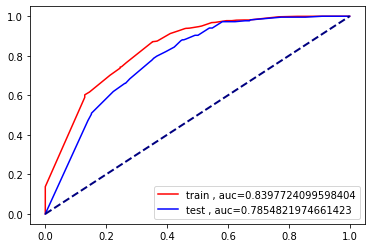

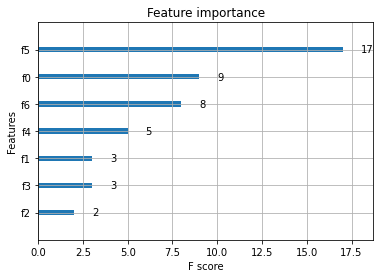

In [ ]:
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,xgb_model_SMOTE_tuned.predict_proba)
xgb.plot_importance(xgb_model_SMOTE_tuned)

XGBoost (grid search) - SMOTE
training set
              precision    recall  f1-score   support

           0       0.94      0.95      0.94      4389
           1       0.95      0.94      0.94      4389

    accuracy                           0.94      8778
   macro avg       0.94      0.94      0.94      8778
weighted avg       0.94      0.94      0.94      8778

test set
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1848
           1       0.24      0.21      0.22       218

    accuracy                           0.85      2066
   macro avg       0.57      0.57      0.57      2066
weighted avg       0.84      0.85      0.84      2066



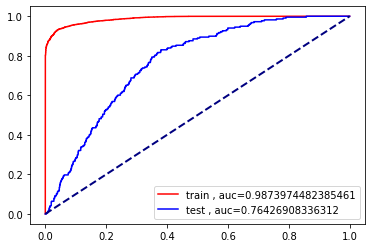

{'colsample_bytree': 0.6, 'early_stopping_rounds': 5, 'eval_metric': 'auc', 'eval_set': (array([[  28.        ,   18.        ,  788.        , ...,    7.        ,
         286.        ,   40.85714286],
       [ 158.        ,   31.        , 2099.        , ...,   12.        ,
         839.        ,   69.91666667],
       [  90.        ,   13.        ,  694.        , ...,    6.        ,
         336.        ,   56.        ],
       ...,
       [  74.        ,   20.        , 1441.        , ...,    4.        ,
         322.        ,   80.5       ],
       [ 191.        ,   19.        , 1259.        , ...,    8.        ,
         561.        ,   70.125     ],
       [  14.        ,   16.        , 1077.        , ...,    8.        ,
         467.        ,   58.375     ]]), 5546    0
3027    1
6234    0
4308    0
3035    0
       ..
2266    0
1303    0
474     0
1789    0
3617    0
Name: response, Length: 2066, dtype: int64), 'gamma': 1, 'max_depth': 5, 'min_child_weight': 1, 'objective': 'binar

In [ ]:
print('XGBoost (grid search) - SMOTE')
gridsearch_xgb_SMOTE = train_model(search_xgb,X_SMOTE, y_SMOTE,X_test, y_test)
plot_roc_xgb(X_SMOTE, y_SMOTE,X_test,y_test,gridsearch_xgb_SMOTE.predict_proba)
print(gridsearch_xgb_SMOTE.best_params_)
#xgb.plot_importance(gridsearch_xgb_SMOTE)

## **Grid Search**

In [ ]:
pipeline = Pipeline(steps=[('estimator', LogisticRegression())])
parameters = [{
                'estimator':[LogisticRegression()],
                'estimator__solver': ['liblinear'],
                'estimator__class_weight': ['balanced'],
                'estimator__penalty' : ['l1', 'l2'],
                'estimator__C': [0.1, 1, 10, 100, 1000]
},
{
                'estimator':[SVC()],
                'estimator__C': [0.1, 1, 10, 100, 1000],
                'estimator__gamma': [0.001, 0.0001],
                'estimator__kernel': ['rbf', 'poly', 'sigmoid']
},
{
                'estimator': [DecisionTreeClassifier()],
                'estimator__criterion' : ['gini','entropy'],
                'estimator__max_depth': [1,2,3,4,5],
                'estimator__max_features': [None, "auto", "sqrt", "log2"],
                'estimator__min_samples_leaf': [1, 5, 10, 20, 50, 100]
},
{
                'estimator': [RandomForestClassifier()],
                'estimator__bootstrap': [True, False],
                'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                'estimator__max_features': ['auto', 'sqrt'],
                'estimator__min_samples_leaf': [1, 2, 4],
                'estimator__min_samples_split': [2, 5, 10],
                'estimator__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
},
{
                'estimator': [xgb.XGBClassifier()],
                'estimator__min_child_weight': [1, 5, 10],
                'estimator__gamma': [0.5, 1, 1.5, 2, 5],
                'estimator__subsample': [0.6, 0.8, 1.0],
                'estimator__colsample_bytree': [0.6, 0.8, 1.0],
                'estimator__max_depth': [3, 4, 5]
}]


In [ ]:
pipeline = Pipeline(steps=[('estimator', LogisticRegression())])
parameters = [{
                'estimator':[LogisticRegression()],
                'estimator__solver': ['liblinear'],
                'estimator__class_weight': ['balanced'],
                'estimator__penalty' : ['l1', 'l2'],
                'estimator__C': [0.1, 1, 10, 100, 1000]
},
{
                'estimator':[SVC()],
                'estimator__C': [0.1, 1, 10, 100, 1000],
                'estimator__gamma': [0.001, 0.0001],
                'estimator__kernel': ['rbf', 'poly', 'sigmoid']
}]

In [ ]:
grid_search_over = GridSearchCV(pipeline, parameters, scoring='roc_auc')
grid_search_over.fit(X_oversampled, y_oversampled)

#print('logistic regression model - undersampled')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [ ]:
  predictions = grid_search_over.predict(X_train)
  predicted_y.extend(predictions)
  expected_y.extend(y_train)
  report_train = classification_report(expected_y, predicted_y)
  print('training set')
  print(report_train) 

  predicted_y = []
  expected_y = []
  predictions = grid_search_over.predict(X_test.to_numpy())
  predicted_y.extend(predictions)
  expected_y.extend(y_test)
  report_test = classification_report(expected_y, predicted_y)
  print('test set')
  print(report_test) 

In [ ]:
print(grid_search_over.best_params_)
plot_roc_logreg(X_oversampled, y_oversampled,X_test,y_test,grid_search_over.decision_function)

{'estimator': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'estimator__C': 1, 'estimator__gamma': 0.001}


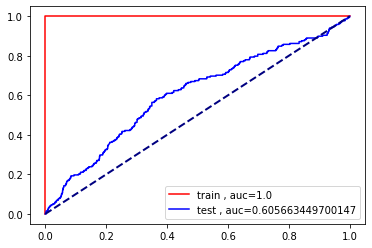

In [ ]:
grid_search_under = GridSearchCV(pipeline, parameters, scoring='roc_auc')
grid_search.fit(X_undersampled, y_undersampled)

In [ ]:
print(grid_search_under.best_params_)
plot_roc_logreg(X_undersampled, y_undersampled,X_test,y_test,grid_search_under.decision_function)